In [45]:
import numpy as np

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'xx-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Full accuracy visualizations

In [46]:
def plot_accuracy_figure(statistics, train_tags):
    
    fig = plt.figure(figsize=(20, 15))

    outer = gridspec.GridSpec(2, 3, wspace=0.5, hspace=0.25)

    for i, statistic in enumerate(statistics):
        train_tag = train_tags[i]
        inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0,
                        subplot_spec=outer[i],
                        height_ratios=[2,1,1])

        ax0 = plt.Subplot(fig, inner[0])
        ax1 = plt.Subplot(fig, inner[1])
        ax2 = plt.Subplot(fig, inner[2])
        axarr = [ax0, ax1, ax2]

        fn_test = '../tables/id_pairs_test.txt'
        id_pairs_test = np.loadtxt(fn_test, delimiter=',', dtype='int')
        n_test = id_pairs_test.shape[0]

        ids_cosmo_unique = set(id_pairs_test[:,0])
        color_idx = np.linspace(0, 1, len(ids_cosmo_unique))

        n_bins = 9
        y_test_dir = '/home/users/ksf293/clust/results_aemulus_test_mean'
        predictions_dir = f'../predictions/predictions_{statistic}{train_tag}'
        ys_test = np.empty((n_test, n_bins))
        ys_pred = np.empty((n_test, n_bins))

        alpha = 0.4
        colors = np.empty((n_test, 4)) # 4 for RGBA
        zorders = np.arange(n_test)
        np.random.shuffle(zorders)
        
        for i in range(n_test):
            id_cosmo, id_hod = id_pairs_test[i]
            y_test_fn = f'{y_test_dir}/results_{statistic}/{statistic}_cosmo_{id_cosmo}_HOD_{id_hod}_mean.dat'
            r_vals, y_test = np.loadtxt(y_test_fn, delimiter=',', unpack=True)
            ys_test[i,:] = y_test

            y_pred_fn = f'{predictions_dir}/{statistic}_cosmo_{id_cosmo}_HOD_{id_hod}.dat'
            _, y_pred = np.loadtxt(y_pred_fn, delimiter=',', unpack=True)
            ys_pred[i,:] = y_pred

            colors[i] = plt.cm.terrain(color_idx[id_cosmo])

            err_frac = (y_pred - y_test)/y_test

            ylabel = stat_labels[statistic]
            if statistic=='xi2':
                y_test *= r_vals**2
                y_pred *= r_vals**2
                axarr[1].set_ylim(-3,3)
                ylabel = r'$s^2$' + ylabel

            label_obs, label_pred = None, None
            if i==0:
                label_obs = 'Mock'
                label_pred = 'Emulator prediction'
            axarr[0].plot(r_vals, y_test, color=colors[i], alpha=alpha, label=label_obs,
                          ls='None', marker='o', markerfacecolor=None, zorder=zorders[i])
            axarr[0].plot(r_vals, y_pred, color=colors[i], alpha=alpha, label=label_pred,
                          marker=None, zorder=zorders[i])

            axarr[1].plot(r_vals, err_frac, color=colors[i], alpha=alpha, zorder=zorders[i])

        errs_frac = (ys_pred - ys_test)/ys_test
        #err_frac_mean = np.std(errs_frac, axis=0)
        err_frac_p16 = np.percentile(errs_frac, 16, axis=0)
        err_frac_p84 = np.percentile(errs_frac, 84, axis=0)
        err_frac_inner68 = (err_frac_p84 - err_frac_p16)/2.0
        #axarr[2].plot(r_vals, err_frac_mean, color='blue', label='error (stdev of fractional error)')
        #axarr[2].plot(r_vals, err_frac_inner68, color='blue', label='emulator error (inner 68%)')
        axarr[2].plot(r_vals, err_frac_p16, color='black', label='Emulator error (inner 68%)')
        axarr[2].plot(r_vals, err_frac_p84, color='black')

        err_fn = f"../../clust/covariances/error_aemulus_{statistic}_hod3_test0.dat"
        sample_var = np.loadtxt(err_fn)
        axarr[2].fill_between(r_dict[statistic], -sample_var, sample_var, color='lightblue', alpha=0.7)
        axarr[2].fill_between(r_dict[statistic], -sample_var/np.sqrt(5), sample_var/np.sqrt(5), color='steelblue', alpha=0.7)

        axarr[0].set_xscale(scale_dict[statistic][0])
        axarr[0].set_yscale(scale_dict[statistic][1])
        axarr[0].set_ylabel(ylabel)
        axarr[0].xaxis.set_tick_params(direction='in', which='both')

        axarr[1].set_xscale(scale_dict[statistic][0])
        axarr[1].xaxis.set_tick_params(labelbottom=True)
        axarr[1].set_ylabel('frac. err.')

        axarr[2].set_xscale(scale_dict[statistic][0])
        axarr[2].set_xlabel(r_labels[statistic])
        axarr[2].set_ylabel('err.')
        axarr[2].axhline(0, color='k', lw=0.5)
        
        fig.add_subplot(axarr[0])
        fig.add_subplot(axarr[1])
        fig.add_subplot(axarr[2])
        
        fig.align_ylabels(axarr)

    handles, labels = axarr[0].get_legend_handles_labels()
    handles2, labels2 = axarr[2].get_legend_handles_labels()
    handles.extend(handles2)
    sample_var_patch = mpatches.Patch(color='lightblue', alpha=0.5, label='Sample variance')
    sample_var_sqrt_patch = mpatches.Patch(color='steelblue', alpha=0.7, label=r'Sample variance / $\sqrt{N_\mathrm{boxes}}$')
    handles.append(sample_var_patch) 
    handles.append(sample_var_sqrt_patch)
    plt.legend(handles=handles, fontsize=18, loc=(1.3, 0.9))

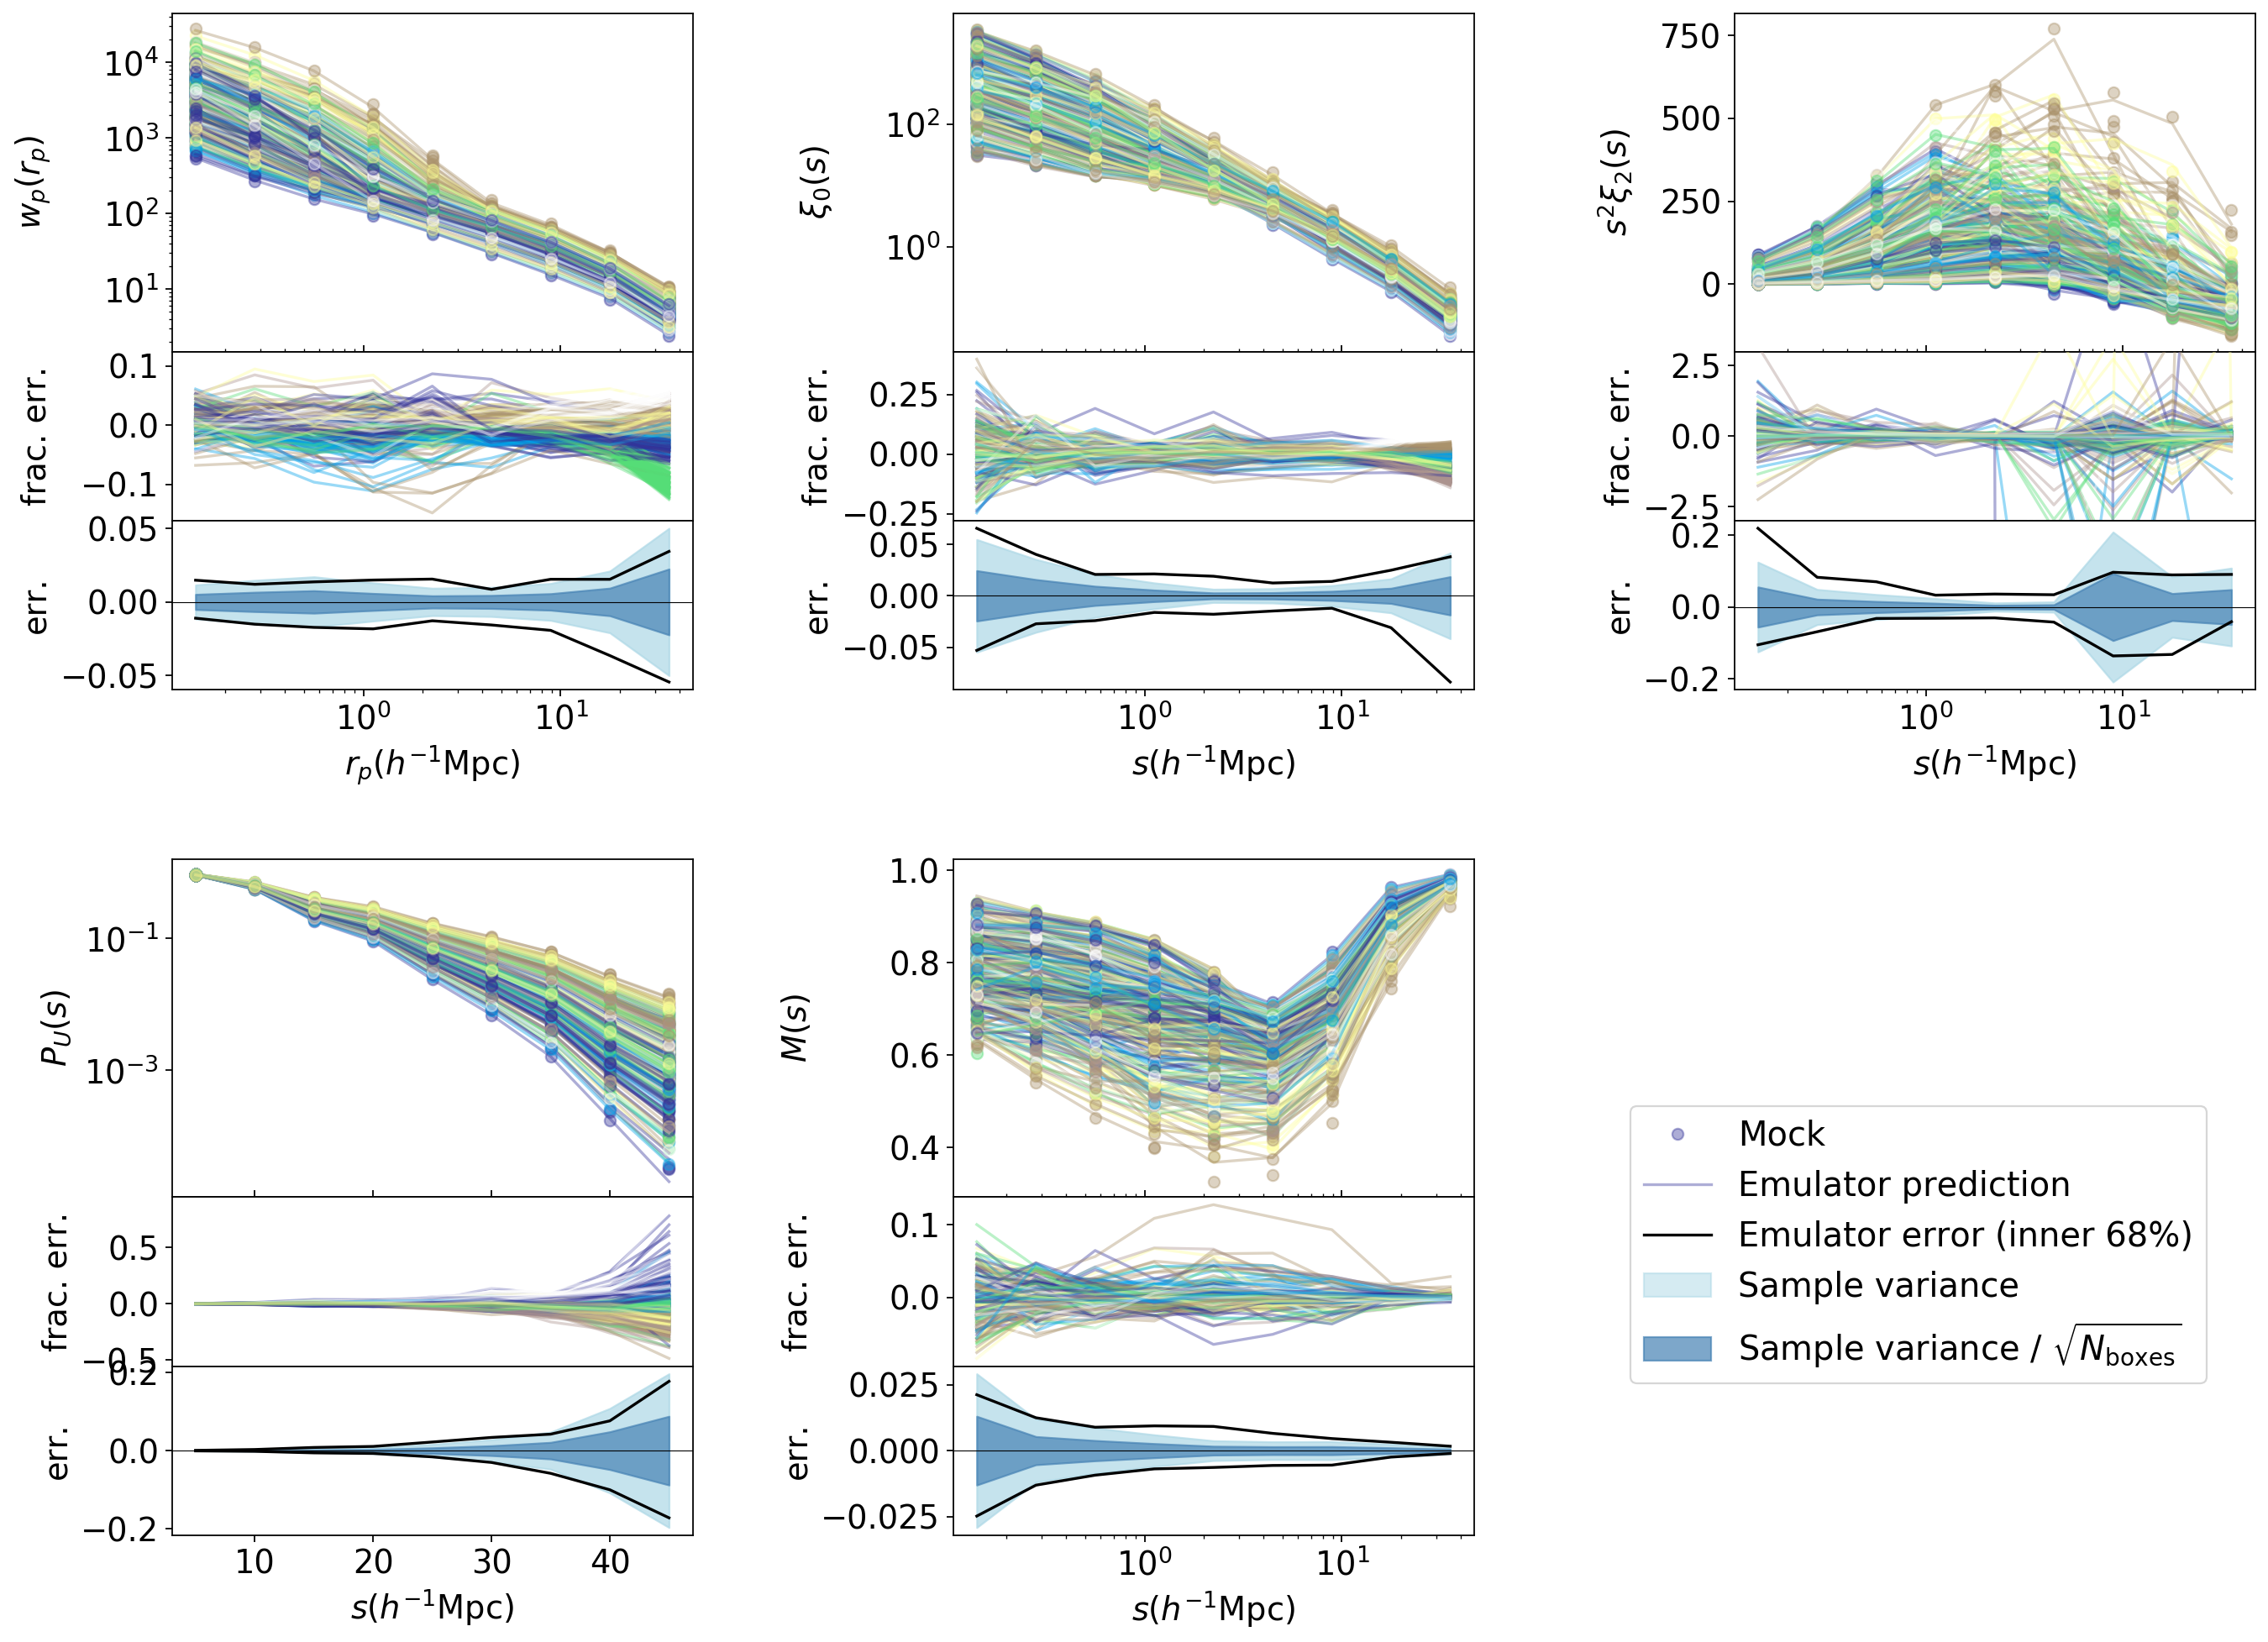

In [47]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
train_tags = [f'_{utils.get_fiducial_emu_name(s)}_{utils.get_fiducial_emu_scaling(s)}' for s in statistics]
plot_accuracy_figure(statistics, train_tags)

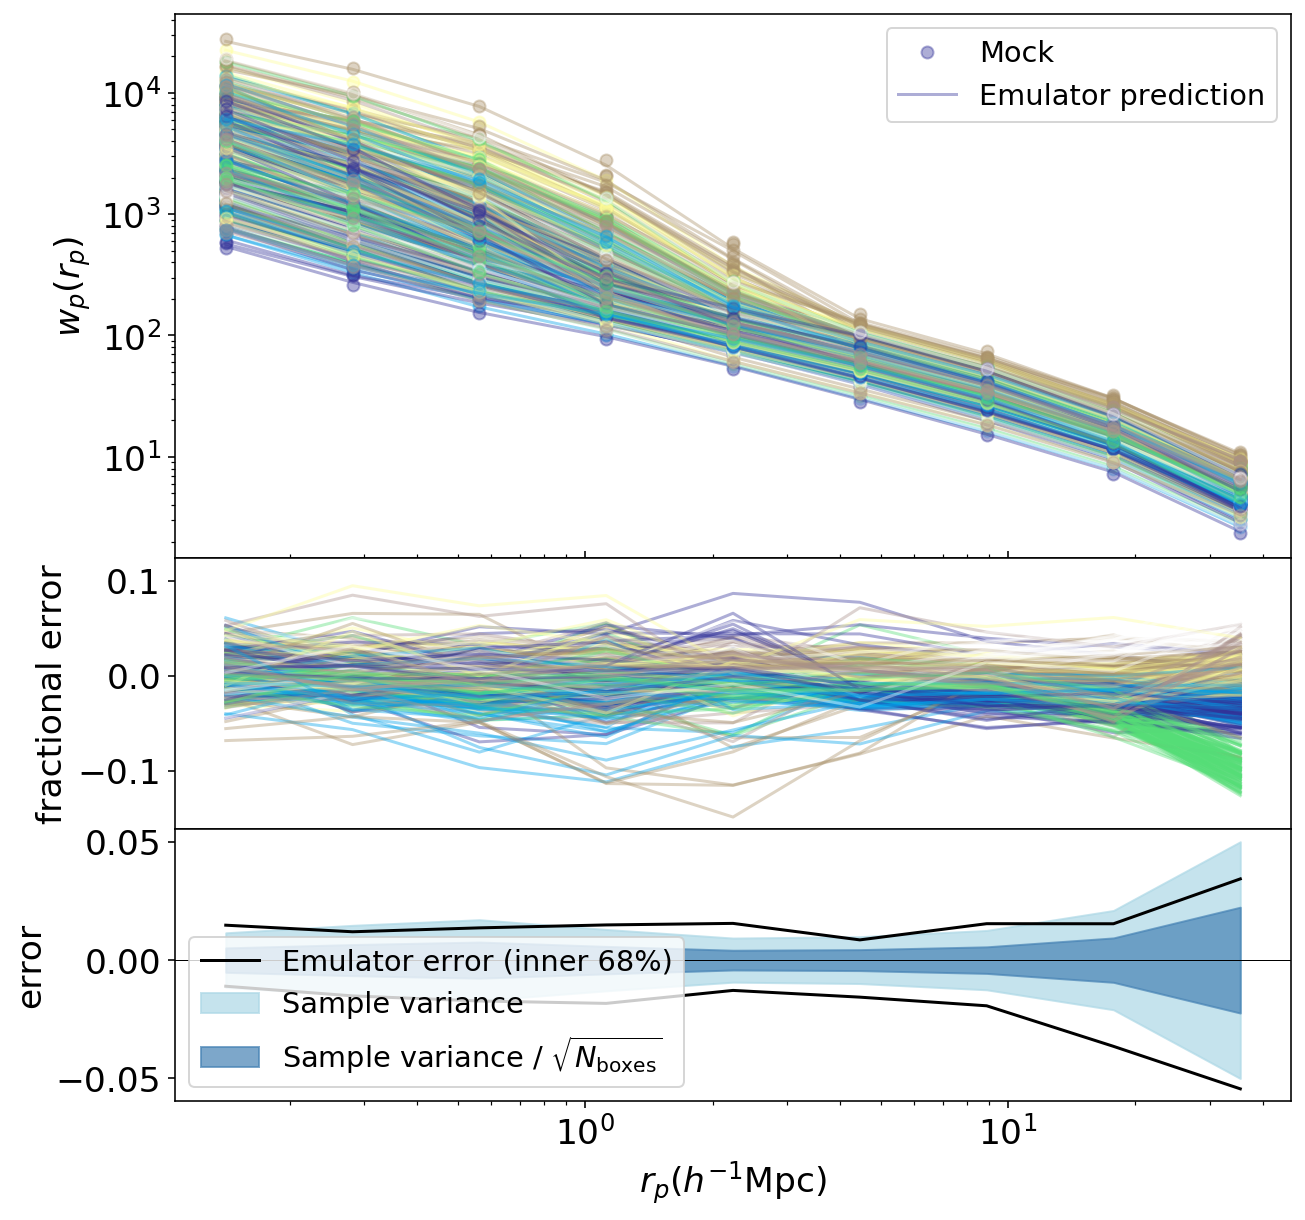

In [13]:
statistic = 'wp'
train_tag = '_George_log'
fracerrs = plotter.plot_accuracy(statistic, train_tag)

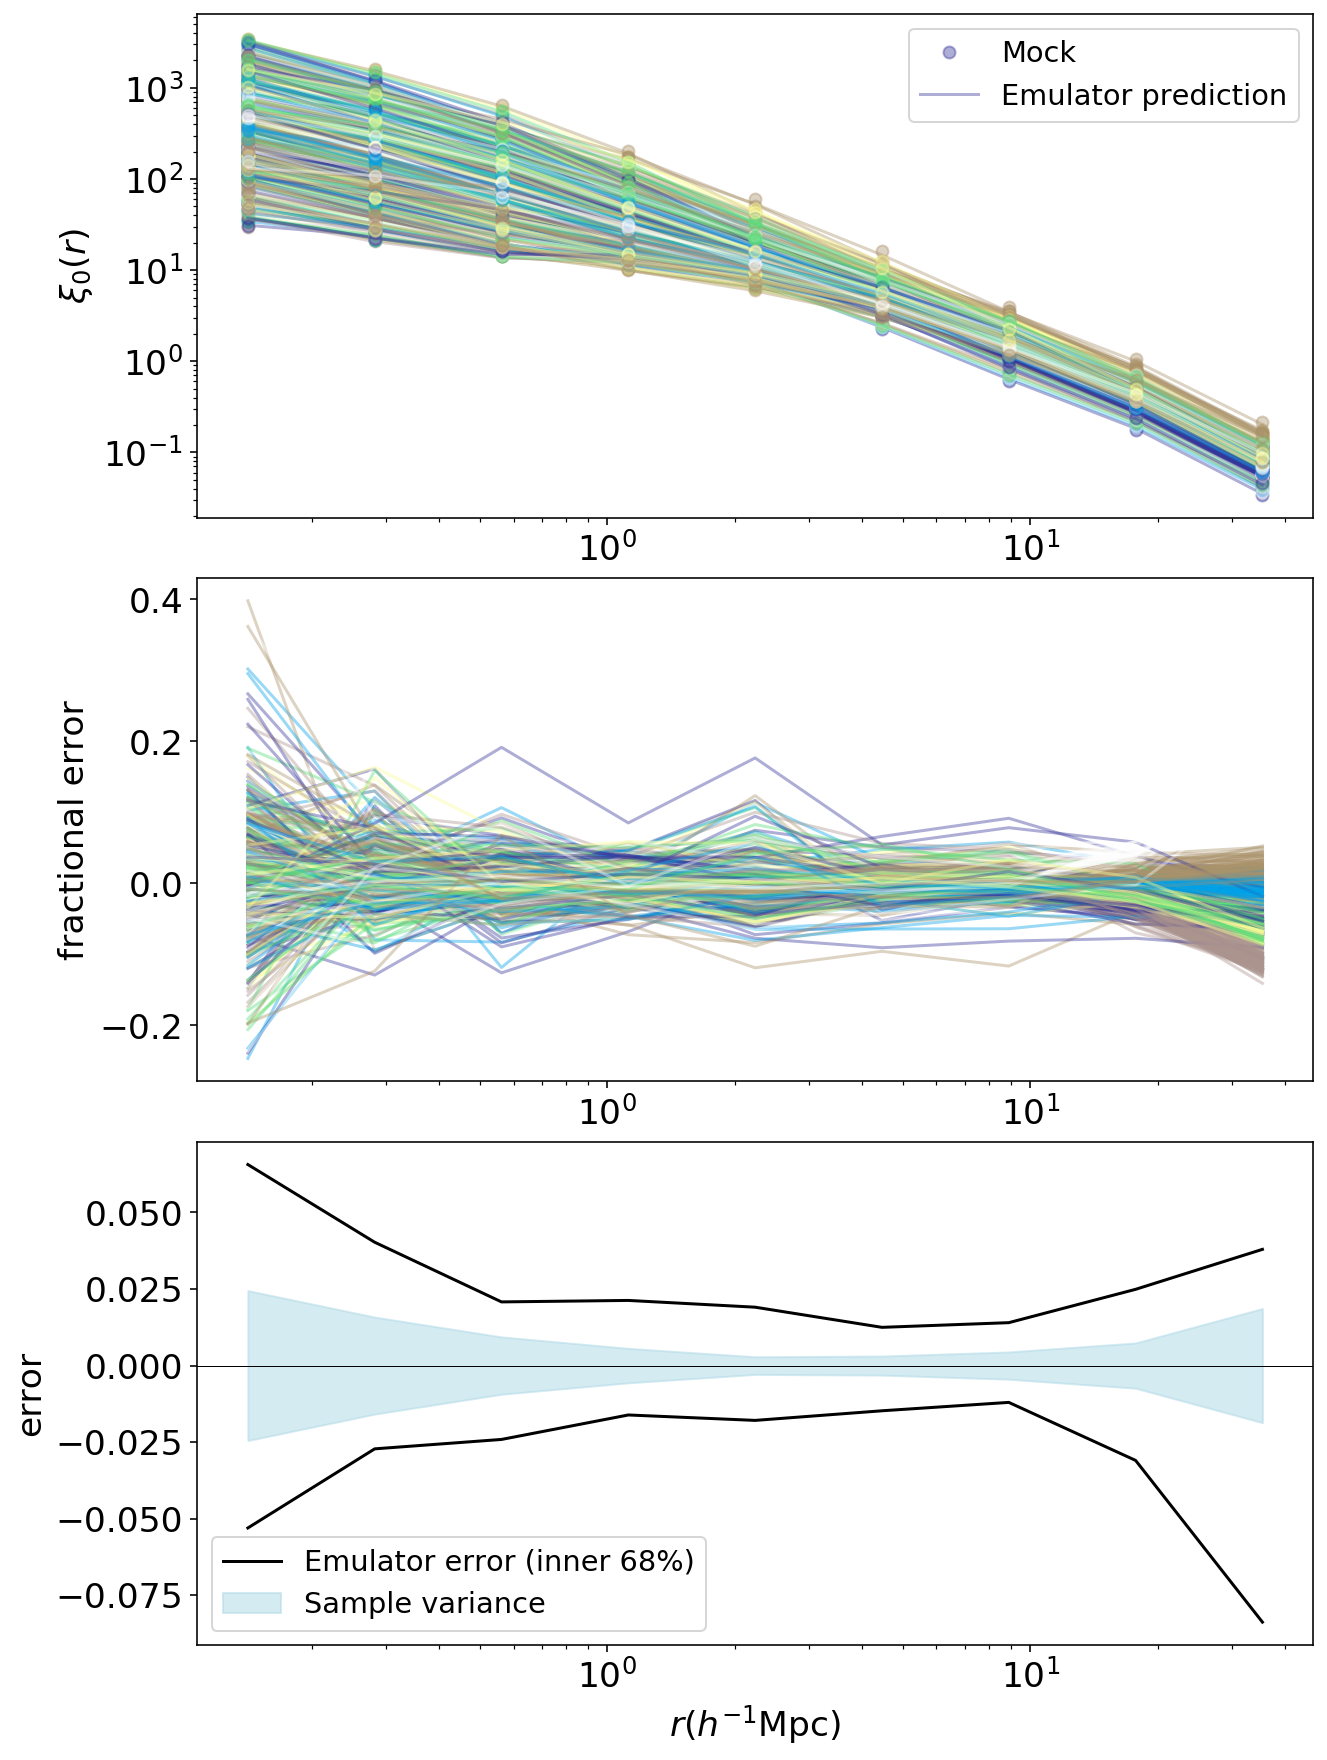

In [7]:
statistic = 'xi'
train_tag = '_George_log'
fracerrs = plotter.plot_accuracy(statistic, train_tag)

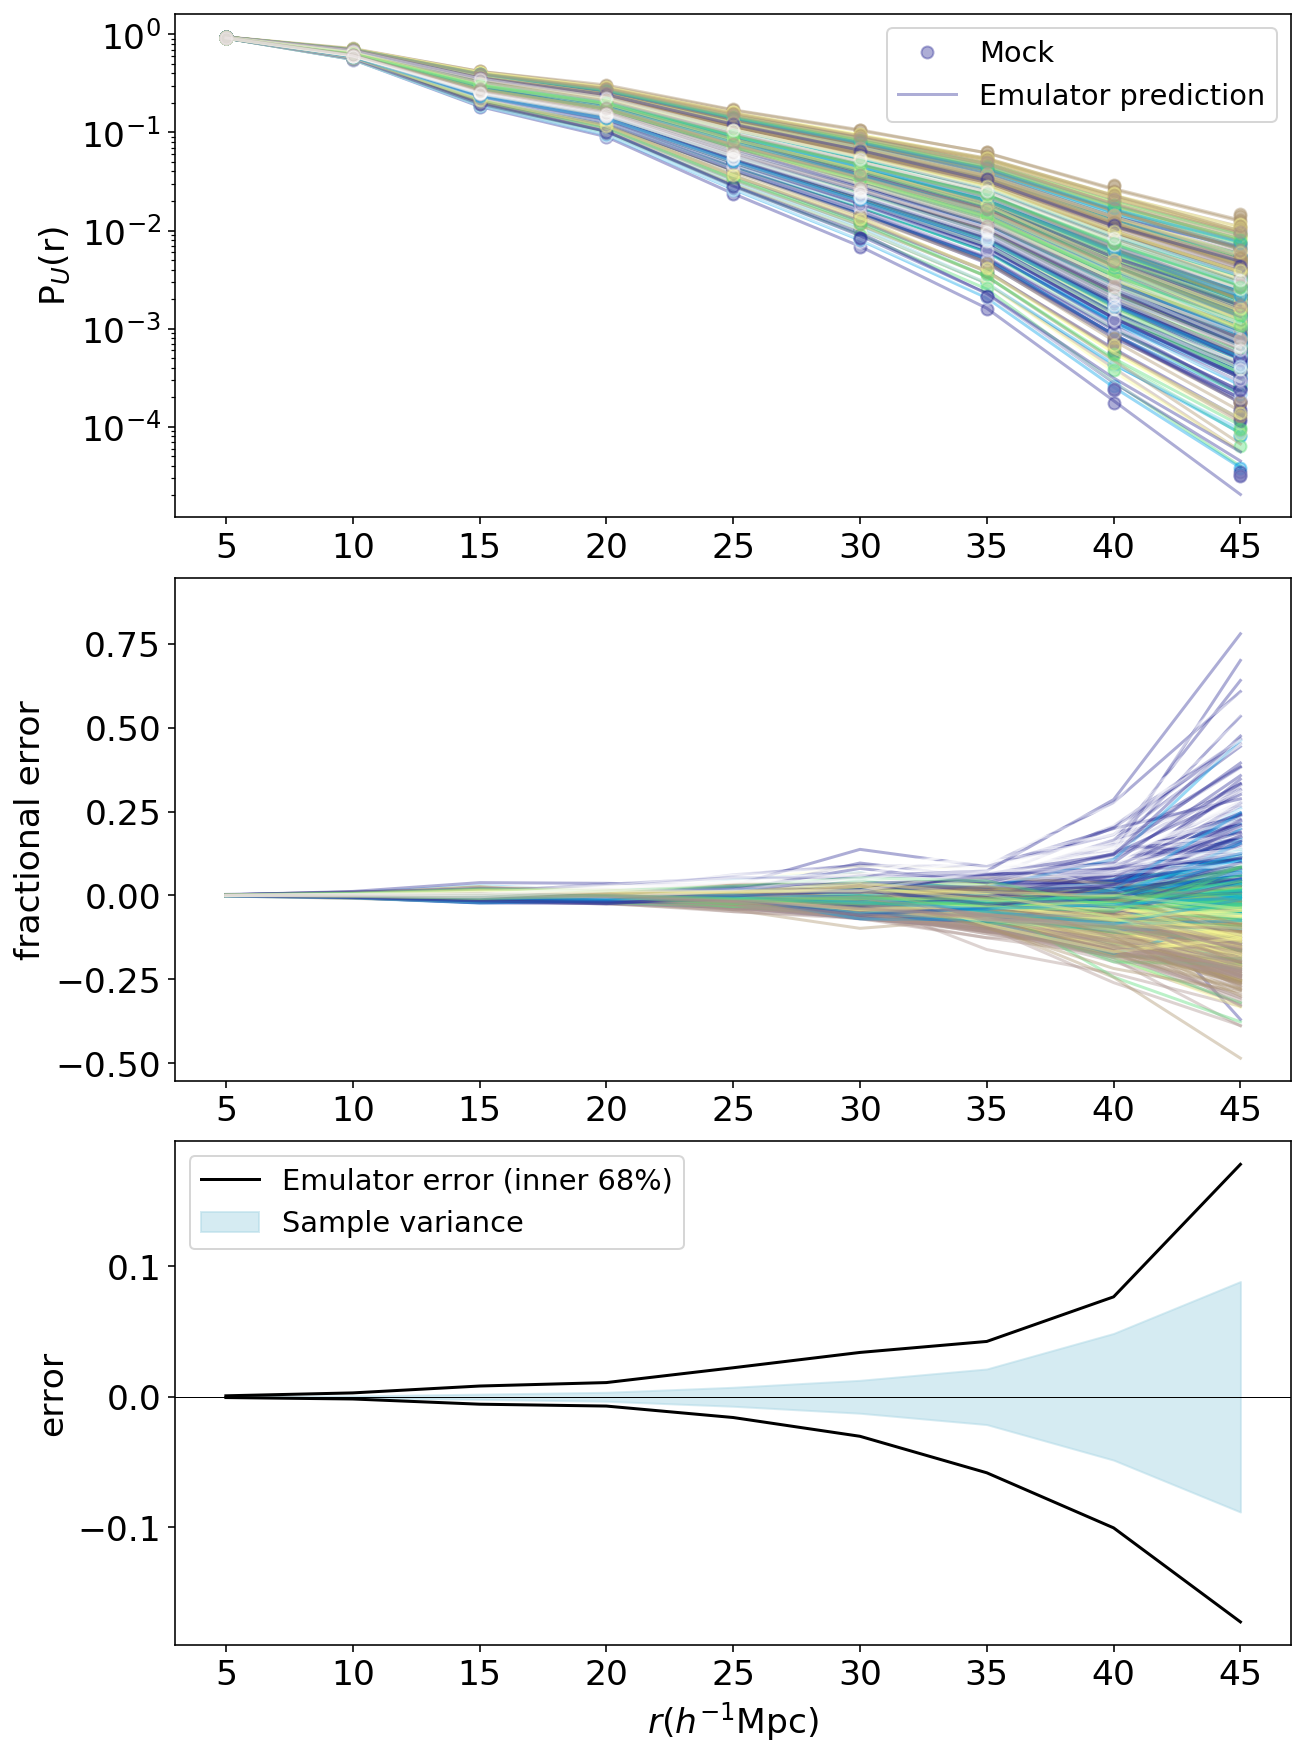

In [8]:
statistic = 'upf'
train_tag = '_George_log'
fracerrs = plotter.plot_accuracy(statistic, train_tag)

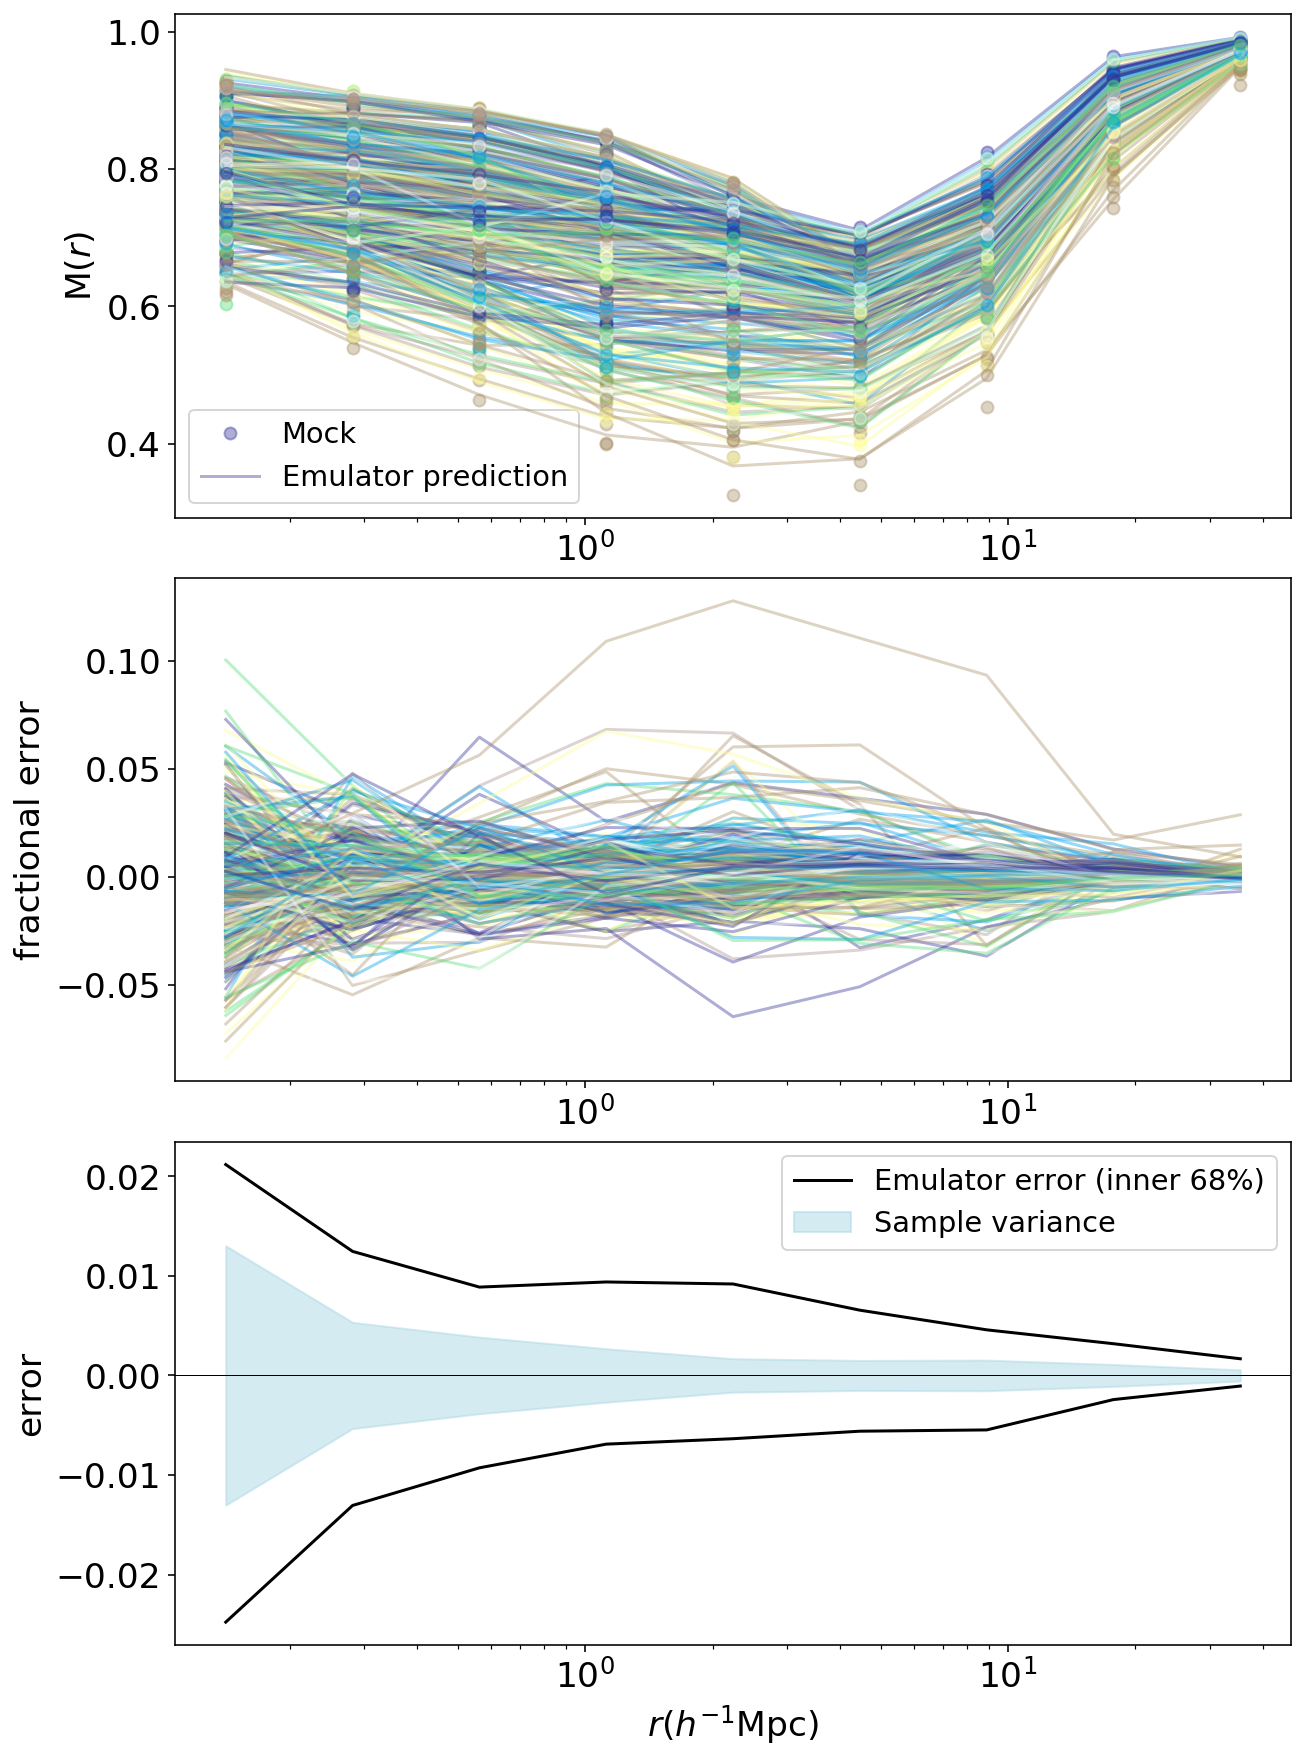

In [9]:
statistic = 'mcf'
train_tag = '_George_log'
fracerrs = plotter.plot_accuracy(statistic, train_tag)

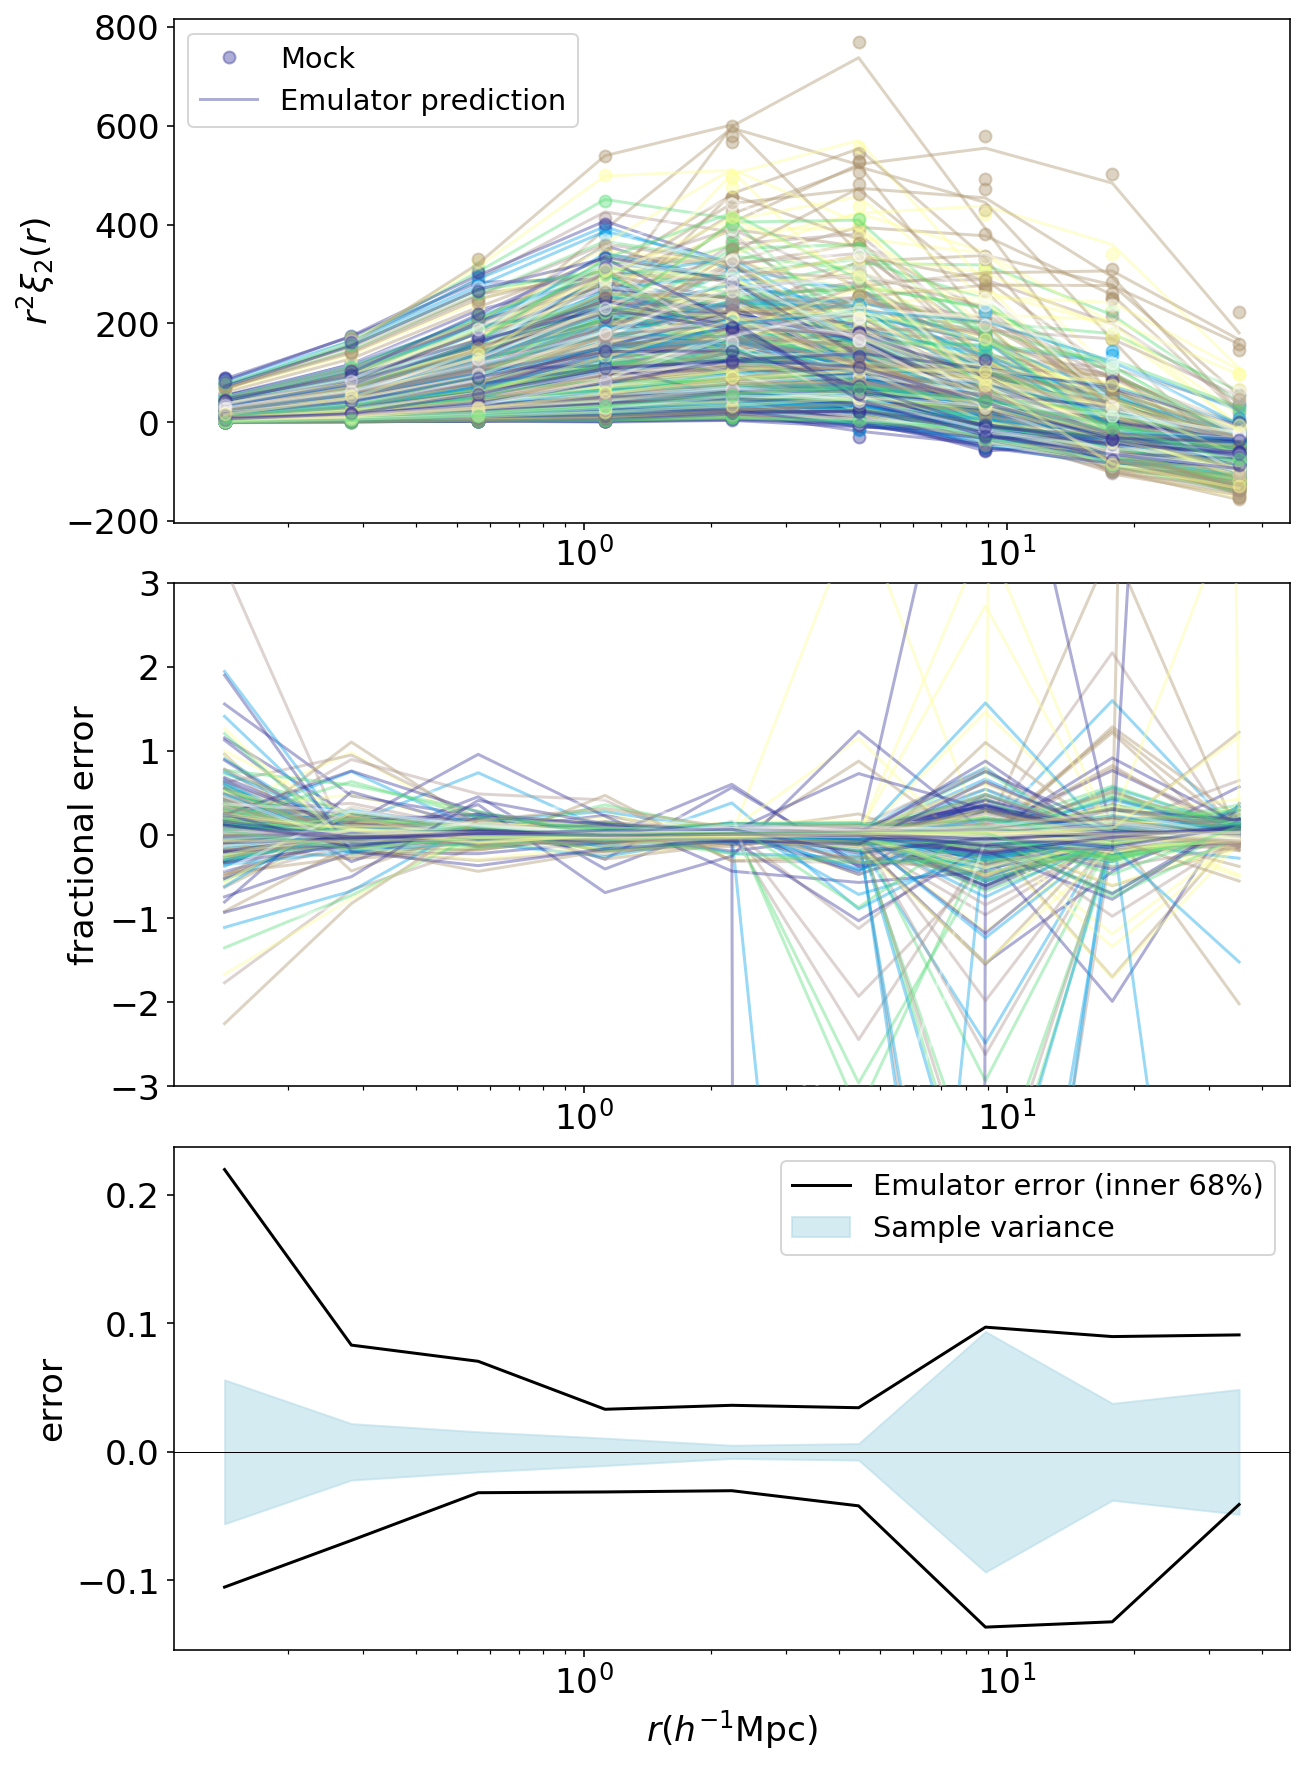

In [11]:
statistic = 'xi2'
train_tag = '_George_xrsqmean'
fracerrs = plotter.plot_accuracy(statistic, train_tag)

## 2-sided errors

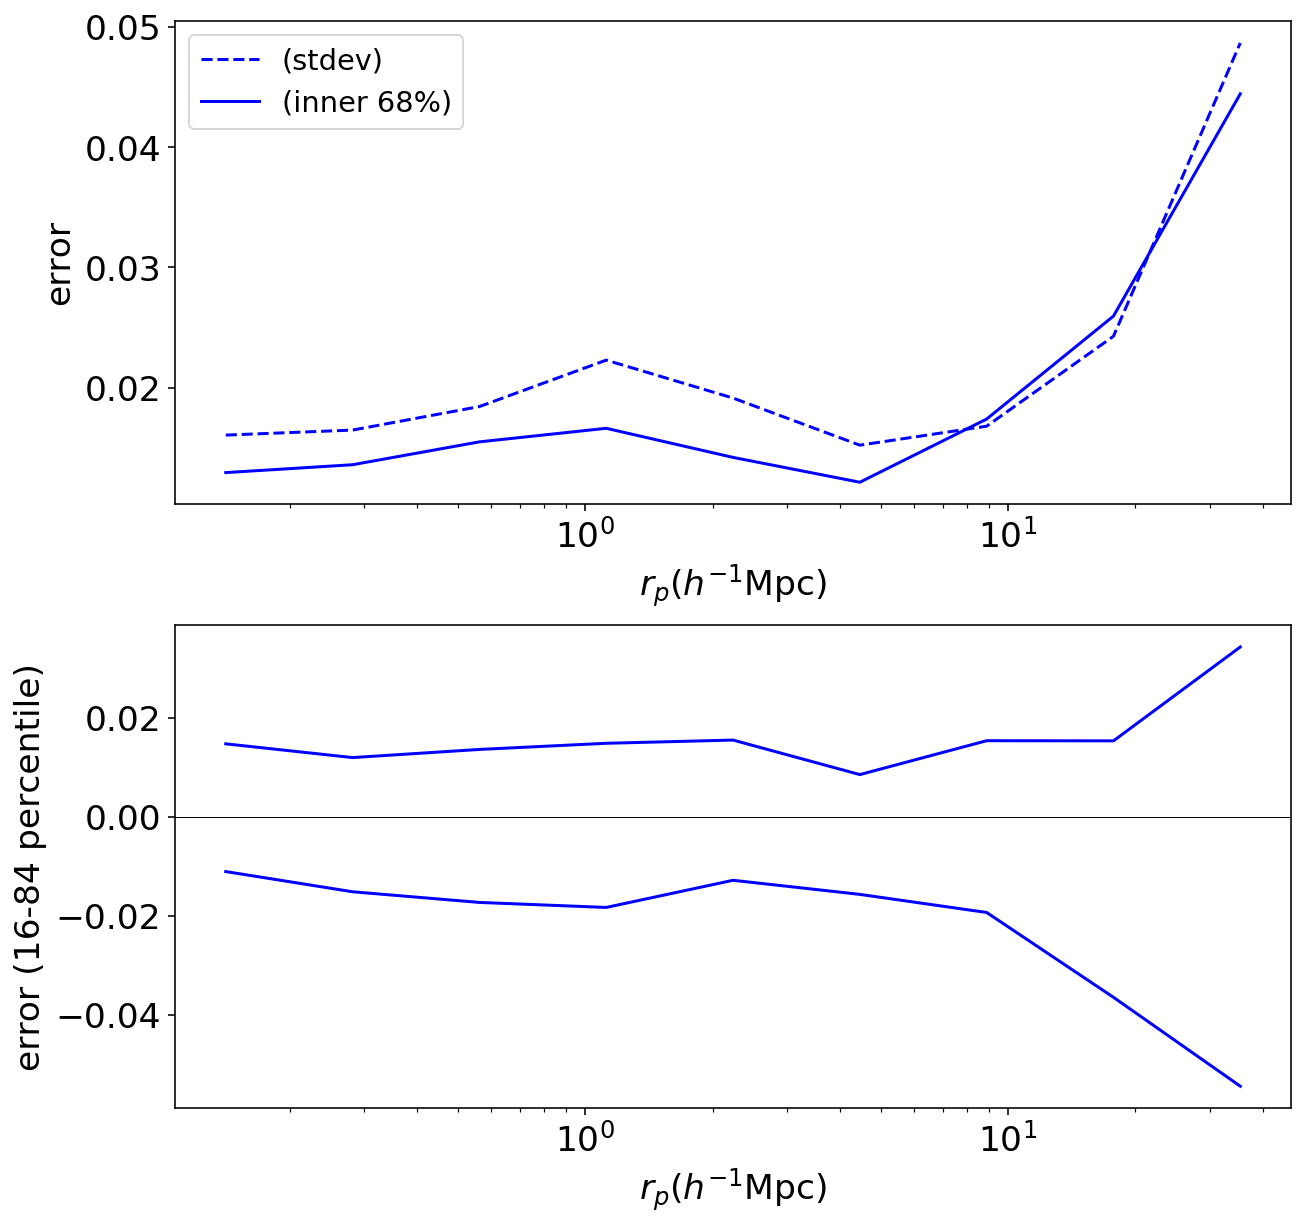

In [7]:
statistic = 'wp'
train_tags = ['_George_log']
labels = ['']
colors = ['blue']
fracerrs = plotter.compare_accuracy(statistic, train_tags, labels, colors)

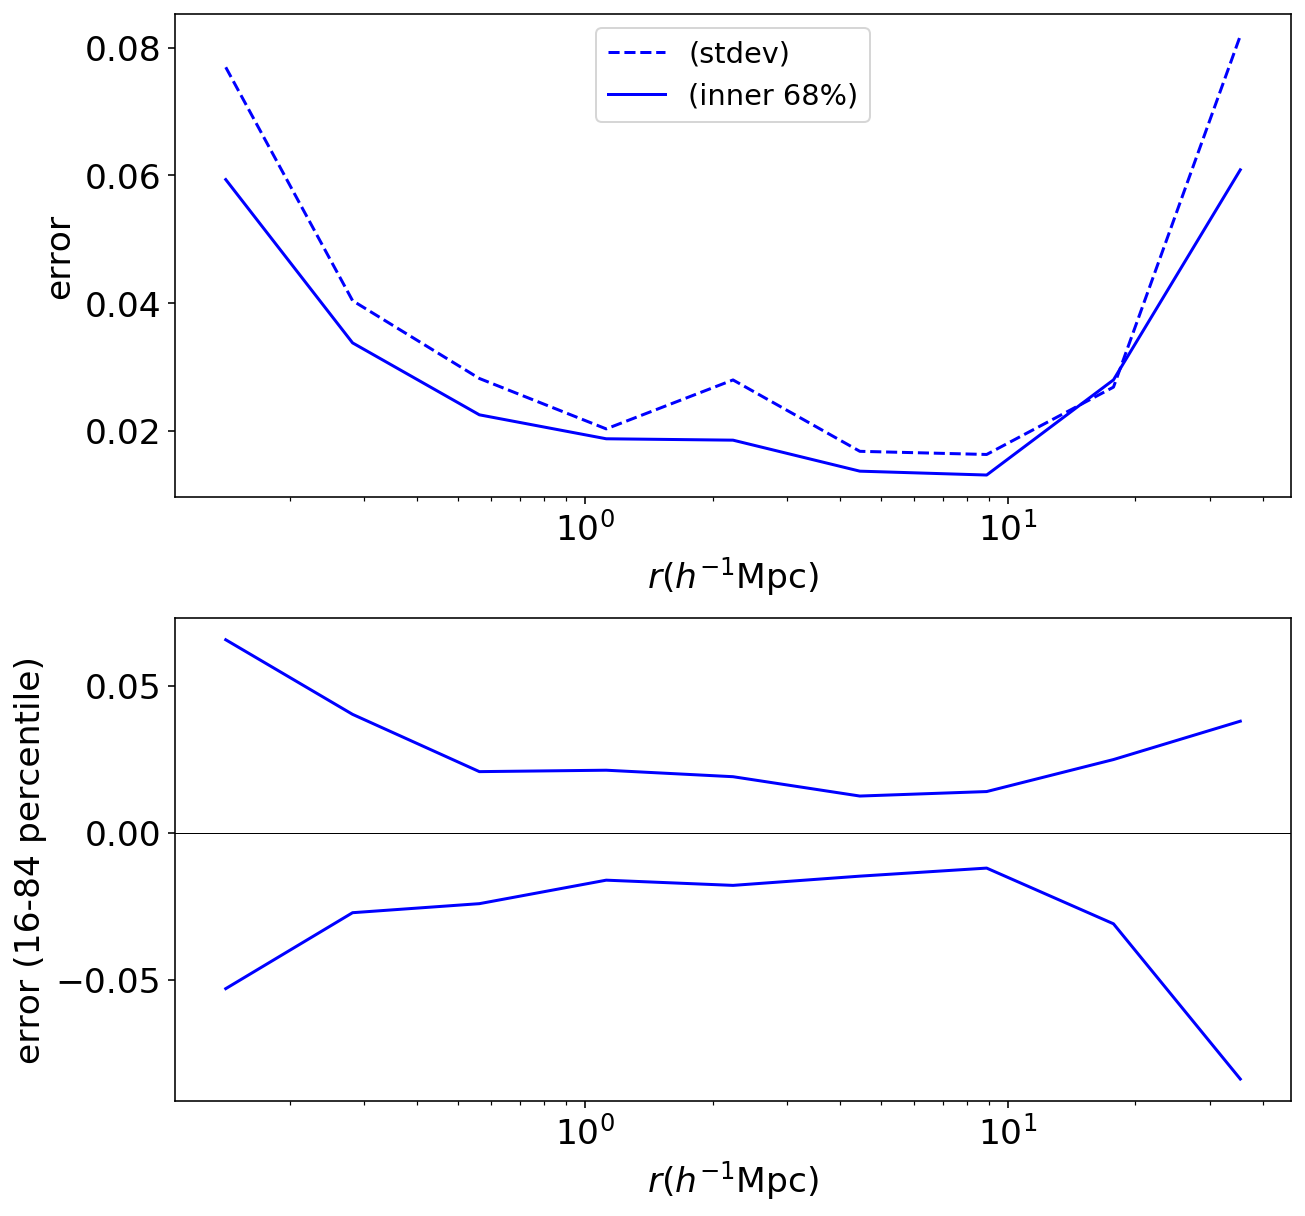

In [8]:
statistic = 'xi'
train_tags = ['_George_log']
labels = ['']
colors = ['blue']
fracerrs = plotter.compare_accuracy(statistic, train_tags, labels, colors)

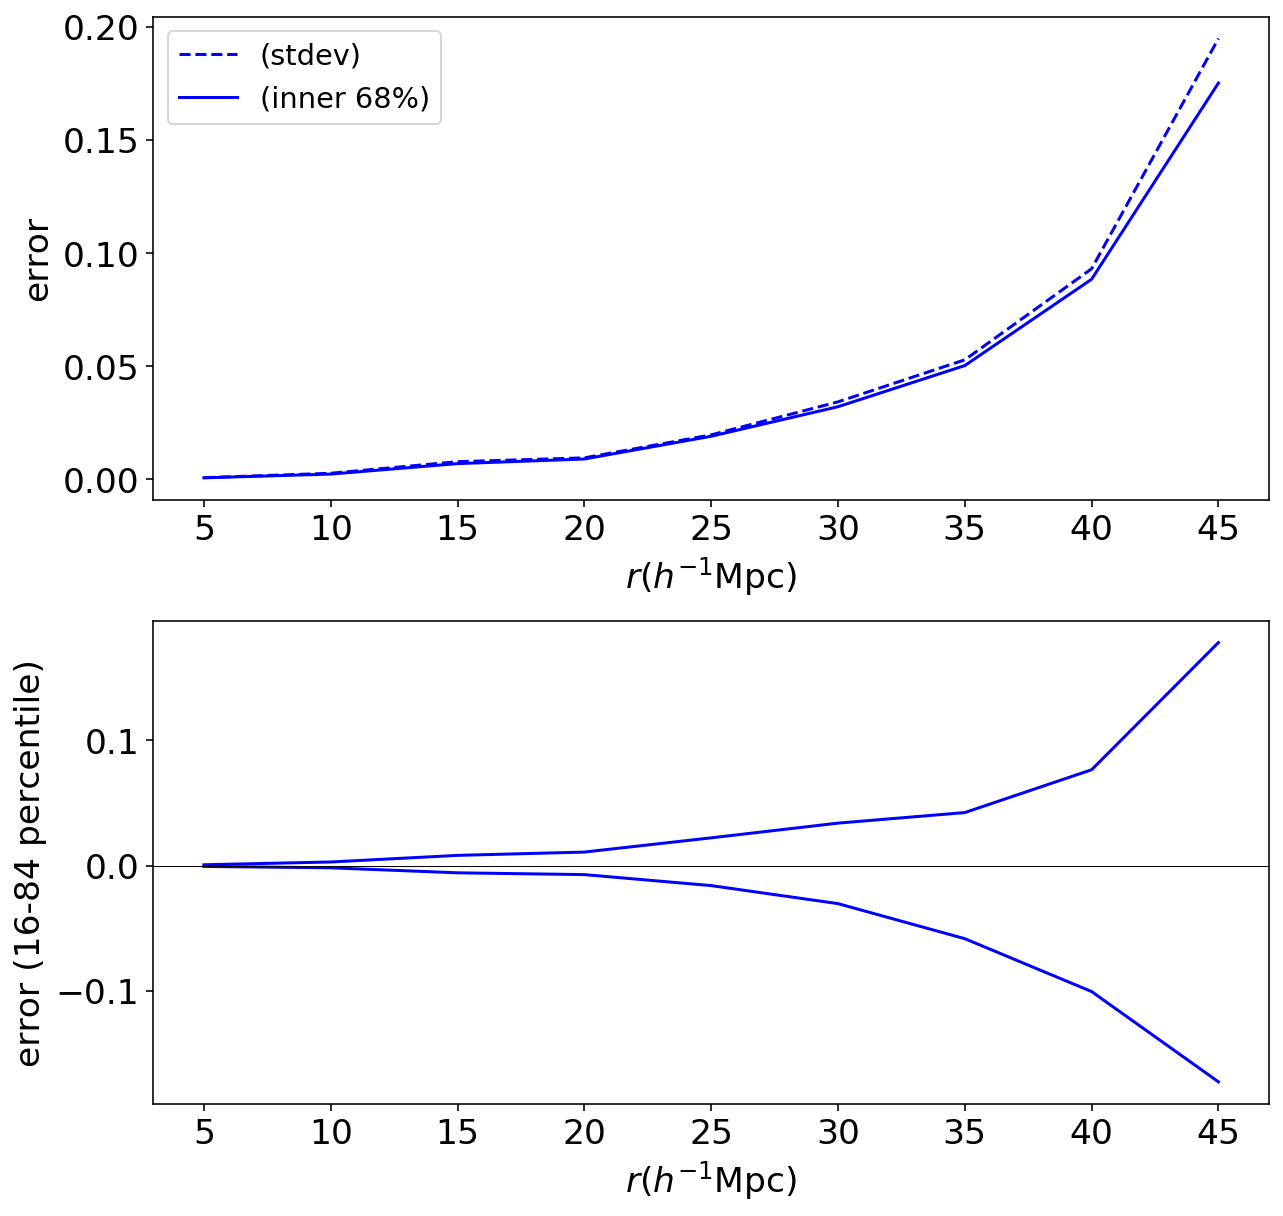

In [9]:
statistic = 'upf'
train_tags = ['_George_log']
labels = ['']
colors = ['blue']
fracerrs = plotter.compare_accuracy(statistic, train_tags, labels, colors)

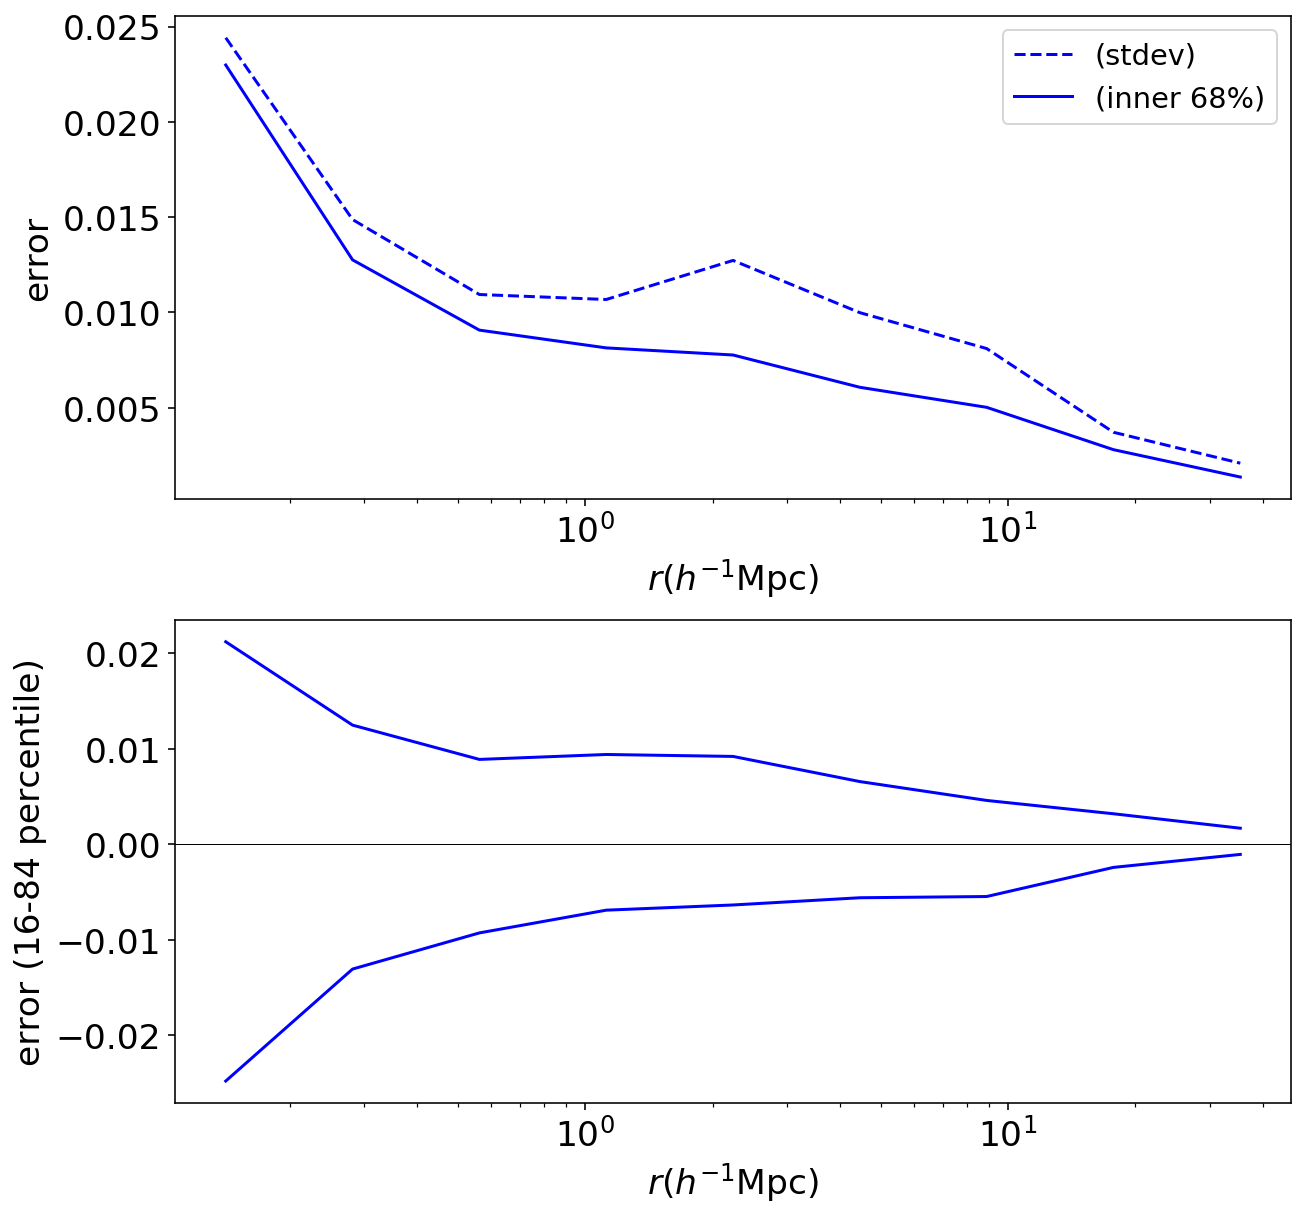

In [10]:
statistic = 'mcf'
train_tags = ['_George_log']
labels = ['']
colors = ['blue']
fracerrs = plotter.compare_accuracy(statistic, train_tags, labels, colors)

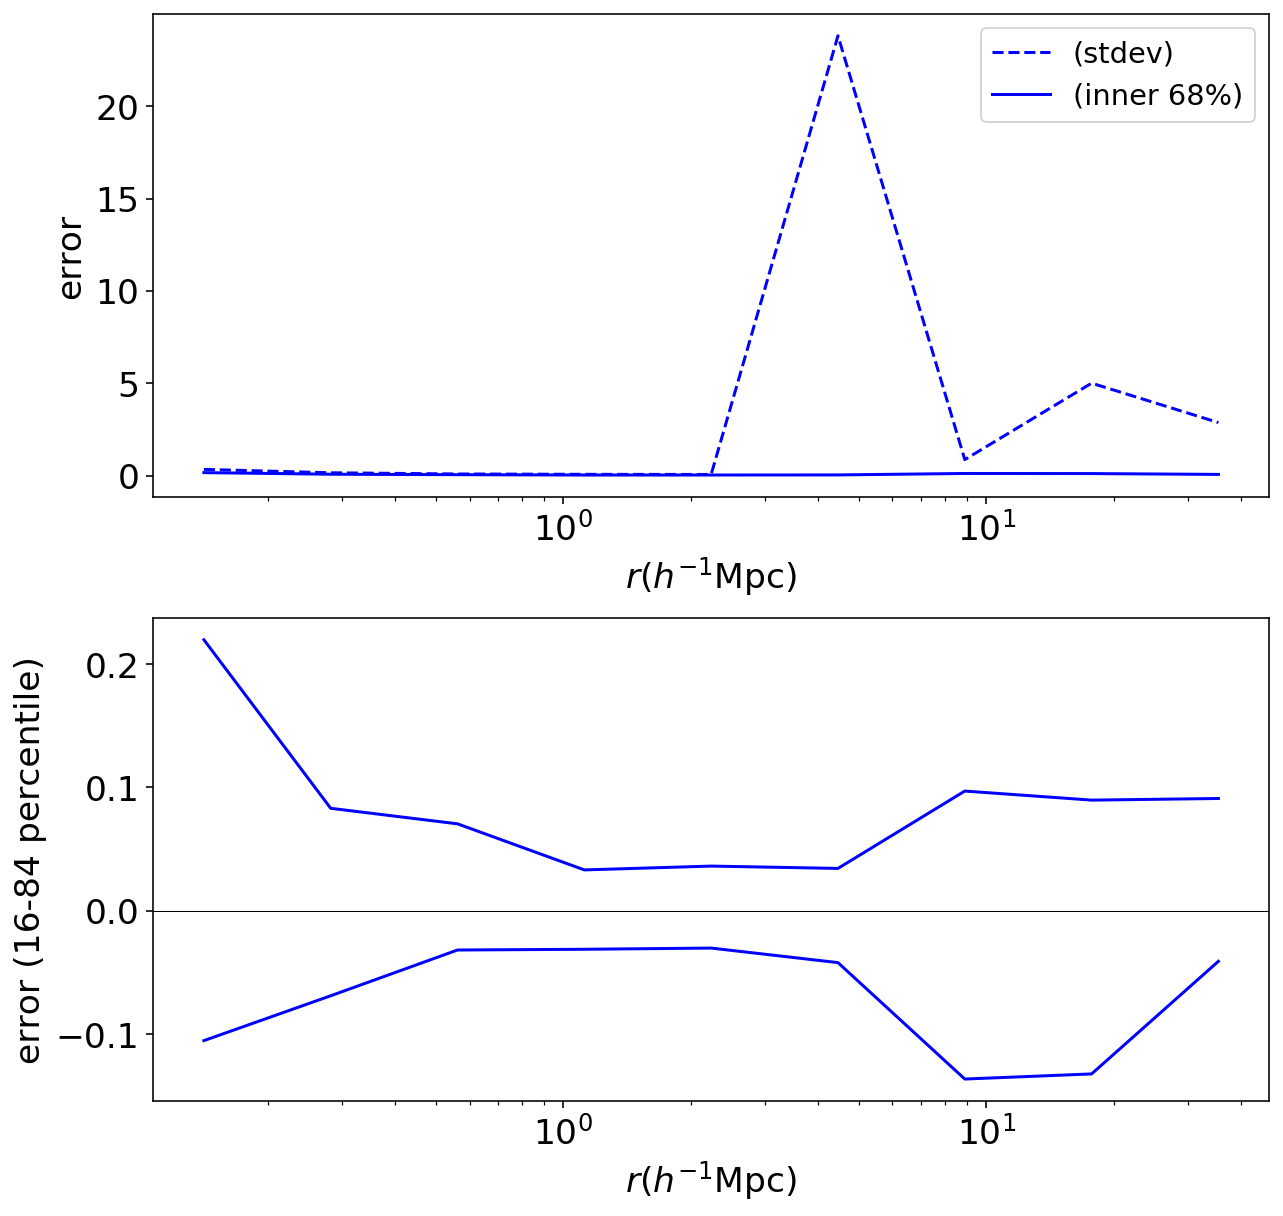

In [11]:
statistic = 'xi2'
train_tags = ['_George_xrsqmean']
labels = ['']
colors = ['blue']
fracerrs = plotter.compare_accuracy(statistic, train_tags, labels, colors)